**Reference**: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder . Chapter 17 of Geron's book.

This file trains an autoencoder with the instances of the normal digit in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digit in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
import os
# import cv2

# The original code

### **Loading the MNIST data and forming arrays of the normal training data, validation data (normal and abnormal, and the test data (normal and abnormal)**

In [ ]:
nl1 = 0   # Normal digit 1
nl2 = 0   # Normal digit 2
abn = 3

(x_train_0, y_train_0), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train_0 = x_train_0.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

train_size = x_train_0.shape[0] * 9 // 10

x_train, x_valid, y_train, y_valid = train_test_split(x_train_0, y_train_0, train_size = train_size)

normal_data = x_train[(y_train == nl1).flatten() | (y_train == nl2).flatten()]    # Normal training data (Normal digits)
normal_labels = y_train[(y_train == nl1).flatten() | (y_train == nl2).flatten()]  

valid_data = x_valid[(y_valid == abn).flatten() | (y_valid == nl1).flatten() | (y_valid == nl2).flatten()]    # Validation data (both normal digits and the abnormal digit)
valid_labels = y_valid[(y_valid == abn).flatten() | (y_valid == nl1).flatten() | (y_valid == nl2).flatten()]

test_data = x_test[(y_test == abn).flatten() | (y_test == nl1).flatten() | (y_test == nl2).flatten()]   # Test data (both normal digits and the abnormal digit)
test_labels = y_test[(y_test == abn).flatten() | (y_test == nl1).flatten() | (y_test == nl2).flatten()]

test_labels_T_F = np.where((test_labels == nl1).flatten() | (test_labels == nl2).flatten(), True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

valid_labels_T_F = np.where((valid_labels == nl1).flatten() | (valid_labels == nl2).flatten(), True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
normal_data.shape, normal_labels.shape, valid_data.shape, valid_labels.shape, test_data.shape, test_labels.shape

((4515, 32, 32, 3),
 (4515, 1),
 (981, 32, 32, 3),
 (981, 1),
 (2000, 32, 32, 3),
 (2000, 1))

In [ ]:
normal_test_data = test_data[(test_labels == nl1).flatten() | (test_labels == nl2).flatten()]   # The normal digits in the test data
abnormal_test_data = test_data[(test_labels == abn).flatten()]                          # The abnormal digits in the test data
normal_test_labels = test_labels[(test_labels == nl1).flatten() | (test_labels == nl2).flatten()]   # Their labels
abnormal_test_labels = test_labels[(test_labels == abn).flatten()]                          # Their labels

In [ ]:
normal_test_data.shape, abnormal_test_data.shape

((1000, 32, 32, 3), (1000, 32, 32, 3))

In [ ]:
normal_valid_data = valid_data[(valid_labels == nl1).flatten() | (valid_labels == nl2).flatten()]   # The normal digits in the valid data
abnormal_valid_data = valid_data[(valid_labels == abn).flatten()]                           # The abnormal digits in the valid data
normal_valid_labels = valid_labels[(valid_labels == nl1).flatten() | (valid_labels == nl2).flatten()]   # Their labels
abnormal_valid_labels = valid_labels[valid_labels == abn]                           # Their labels

In [ ]:
normal_valid_data.shape, abnormal_valid_data.shape

((485, 32, 32, 3), (496, 32, 32, 3))

### **Building and training the network** 

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        Input(shape=(32, 32, 3)),
        # Conv2D(128, (3, 3), padding='same'),
        # Conv2D(128, (3, 3), padding='same'),
        # BatchNormalization(),
        # Activation('selu'),
        # MaxPooling2D((2, 2), padding='same'),
        Conv2D(64, (3, 3), padding='same'),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(32, (3, 3), padding='same'),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2), padding='same'),
        Conv2D(16, (3, 3), padding='same'),
        Conv2D(16, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2), padding='same')])


    self.decoder = tf.keras.Sequential([
        Conv2D(16, (3, 3), padding='same'),
        Conv2D(16, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        UpSampling2D((2, 2)),
        Conv2D(32, (3, 3), padding='same'),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        UpSampling2D((2, 2)),
        Conv2D(64, (3, 3), padding='same'),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        UpSampling2D((2, 2)),
      #  Conv2D(128, (3, 3), padding='same'),
      #  Conv2D(128, (3, 3), padding='same'),
      #  BatchNormalization(),
      #  Activation('selu'),
      #  UpSampling2D((2, 2)),
        Conv2D(3, (3, 3), padding='same'),
        Conv2D(3, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('sigmoid')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()



In [ ]:
# autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("AE_model", monitor="val_loss", save_best_only=True)

history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=128,
          validation_data=(normal_valid_data, normal_valid_data),
          callbacks=[checkpoint_cb],
          shuffle=True)

Epoch 1/100
36/36 [==============================] - 16s 149ms/step - loss: 0.6430 - val_loss: 0.6585
Epoch 2/100
36/36 [==============================] - 1s 20ms/step - loss: 0.6032 - val_loss: 0.8228
Epoch 3/100
36/36 [==============================] - 1s 19ms/step - loss: 0.5945 - val_loss: 1.0423
Epoch 4/100
36/36 [==============================] - 1s 20ms/step - loss: 0.5898 - val_loss: 0.9791
Epoch 5/100
36/36 [==============================] - 1s 20ms/step - loss: 0.5856 - val_loss: 1.3610
Epoch 6/100
36/36 [==============================] - 1s 20ms/step - loss: 0.5828 - val_loss: 1.6999
Epoch 7/100
36/36 [==============================] - 1s 21ms/step - loss: 0.5801 - val_loss: 0.9238
Epoch 8/100
36/36 [==============================] - 1s 20ms/step - loss: 0.5780 - val_loss: 1.0876
Epoch 9/100
36/36 [==============================] - 1s 20ms/step - loss: 0.5769 - val_loss: 0.7695
Epoch 10/100
36/36 [==============================] - 1s 20ms/step - loss: 0.5750 - val_loss: 0.77

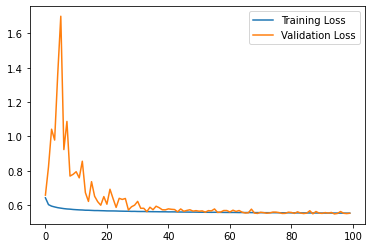

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
model = autoencoder
model.summary(expand_nested=True, show_trainable=True)

Model: "anomaly_detector"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential (Sequential)     (None, 4, 4, 16)          73824     Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d (Conv2D)           (None, 32, 32, 64)        1792      Y          |
|                                                                          |
| conv2d_1 (Conv2D)         (None, 32, 32, 64)        36928     Y          |
|                                                                          |
| batch_normalization (BatchN  (None, 32, 32, 64)     256       Y          |
| ormalization)                                                            |
|                                                                          |
| activation (Activation)   (None, 32, 32, 64)        0         Y          |
|                                                 

In [ ]:
model_encoder = autoencoder.encoder
# model_encoder.summary(expand_nested=True, show_trainable=True)

In [ ]:
model_decoder = autoencoder.decoder
# model_decoder.summary(expand_nested=True, show_trainable=True)

In [ ]:
model_layers = np.array(model.layers)
n_layers = model_layers.shape[0] 
# np.concatenate((np.arange(n_layers).reshape(n_layers,1), model_layers.reshape(n_layers,1)), axis = 1)

### **The original and reconstructed images for the first 30 instances of the normal training data, validation data, normal validation data, abnormal validation data, test data, normal test data, and abnormal test data**

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [ ]:
def show_reconstructions(autoencoder, images, n_images=5):
    encoded_data = autoencoder.encoder(images[:n_images]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    reconstructions = decoded_data
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

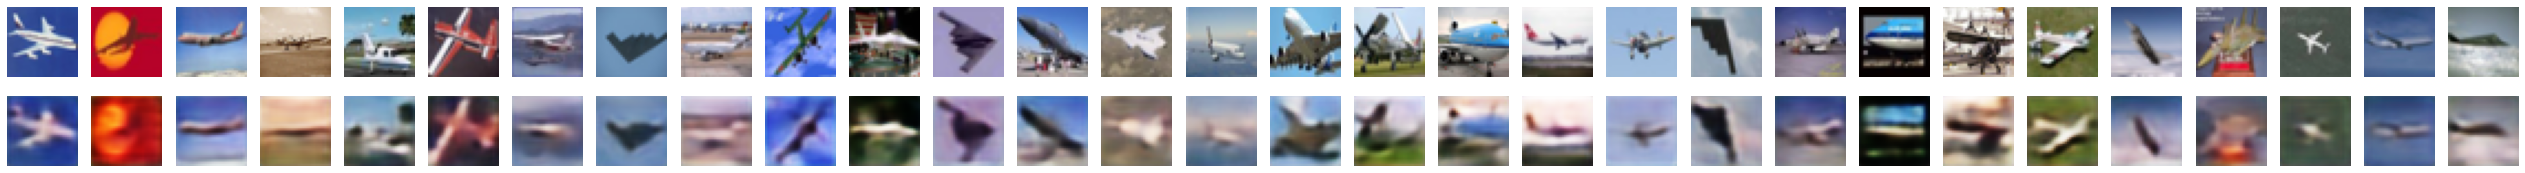

In [ ]:
show_reconstructions(autoencoder, normal_data, 30)
plt.show()

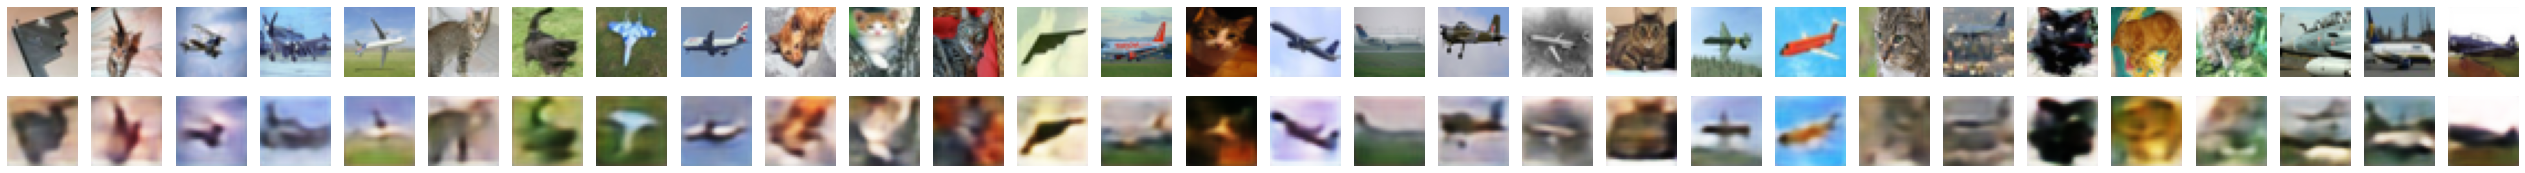

In [ ]:
show_reconstructions(autoencoder, valid_data, 30)
plt.show()

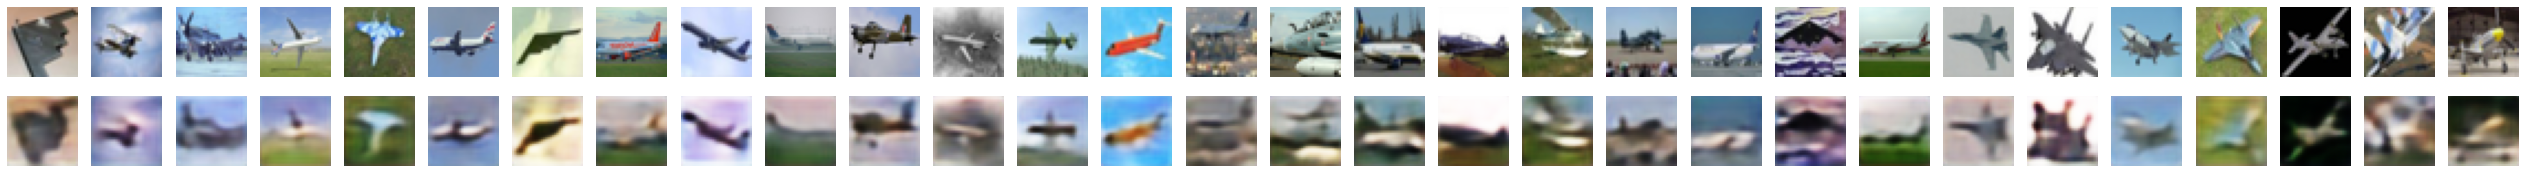

In [ ]:
show_reconstructions(autoencoder, normal_valid_data, 30)
plt.show()

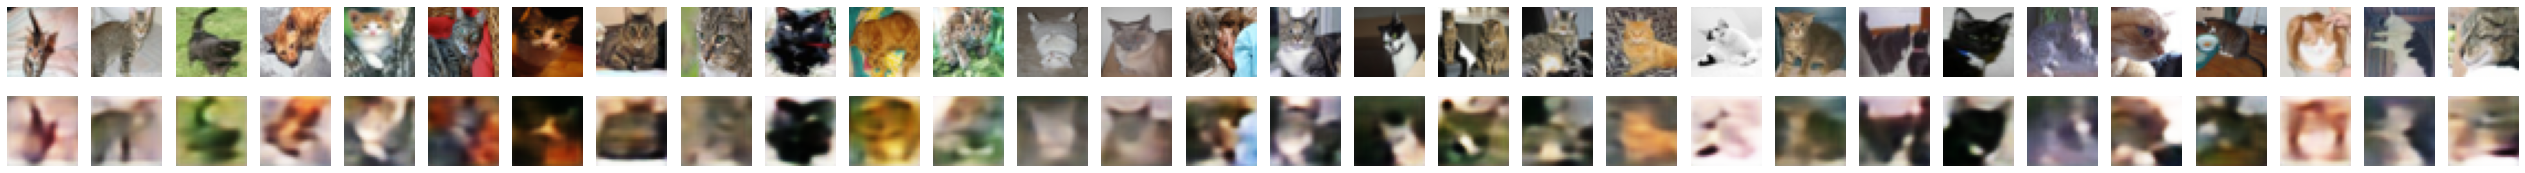

In [ ]:
show_reconstructions(autoencoder, abnormal_valid_data, 30)
plt.show()

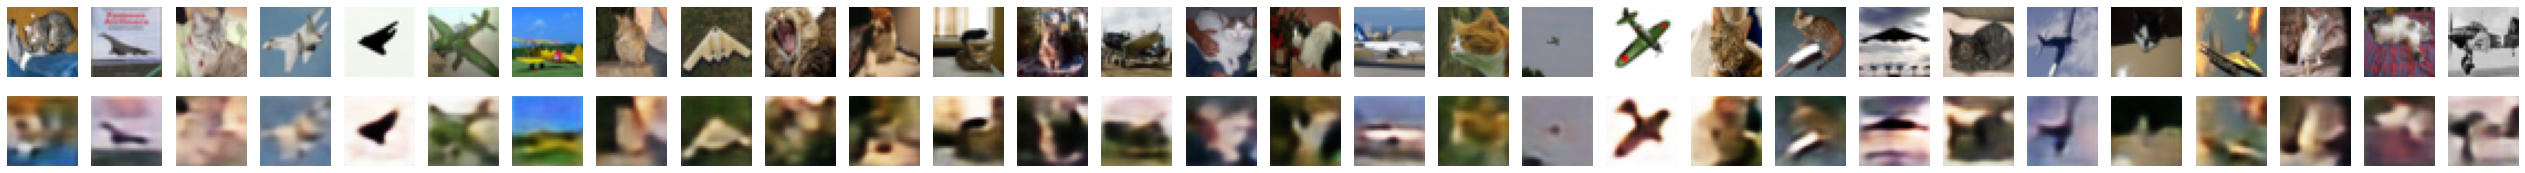

In [ ]:
show_reconstructions(autoencoder, test_data, 30)
plt.show()

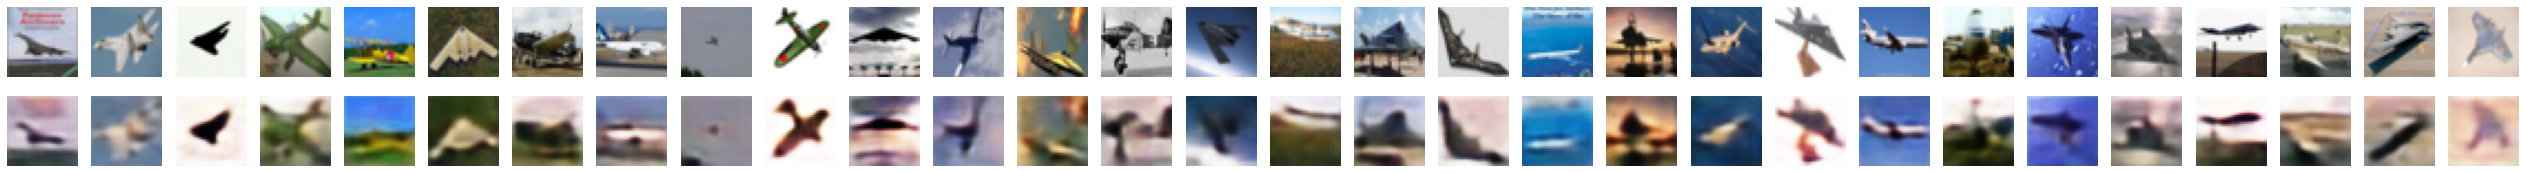

In [ ]:
show_reconstructions(autoencoder, normal_test_data, 30)
plt.show()

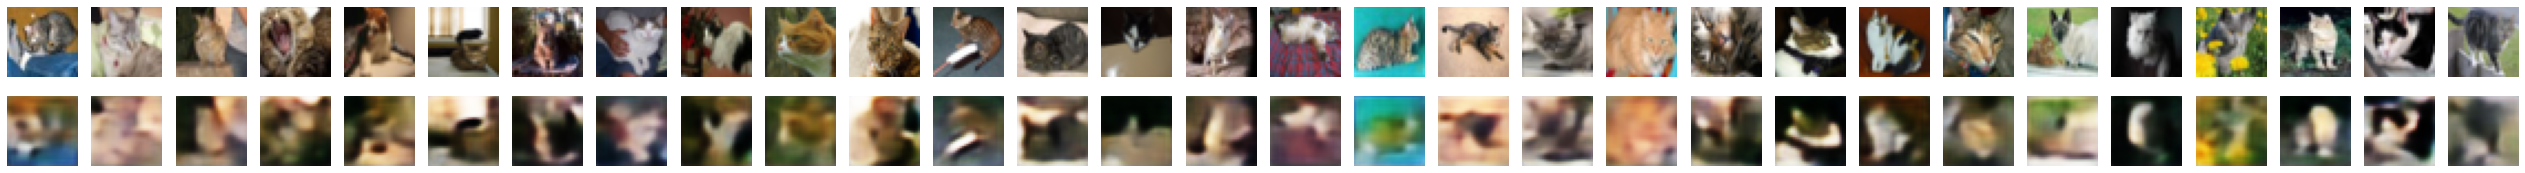

In [ ]:
show_reconstructions(autoencoder, abnormal_test_data, 30)
plt.show()

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

**1-Dim plot of pixels of the first normal test data**

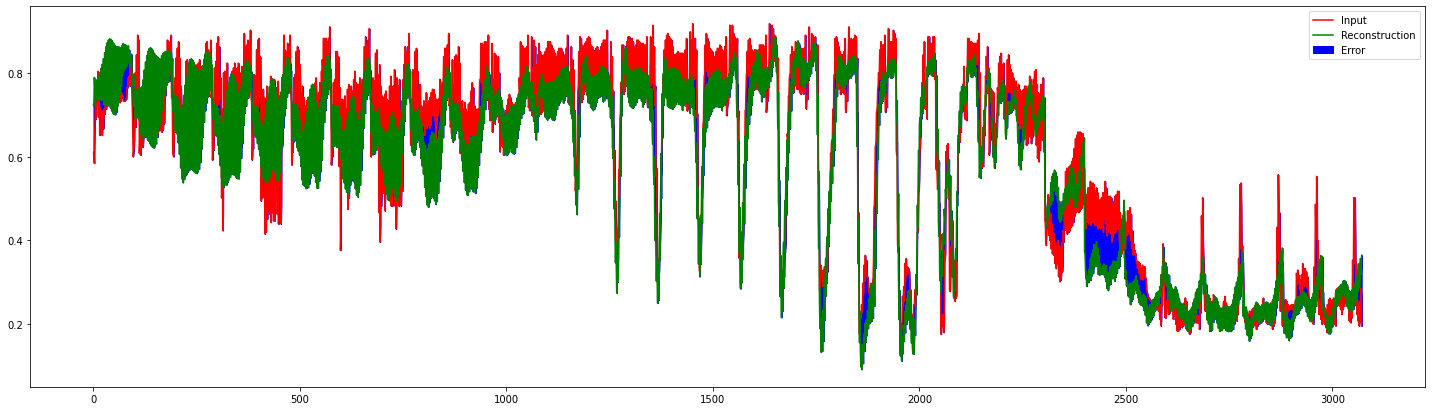

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(32*32*3), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

**1-Dim plot of pixels of the first abnormal test data**

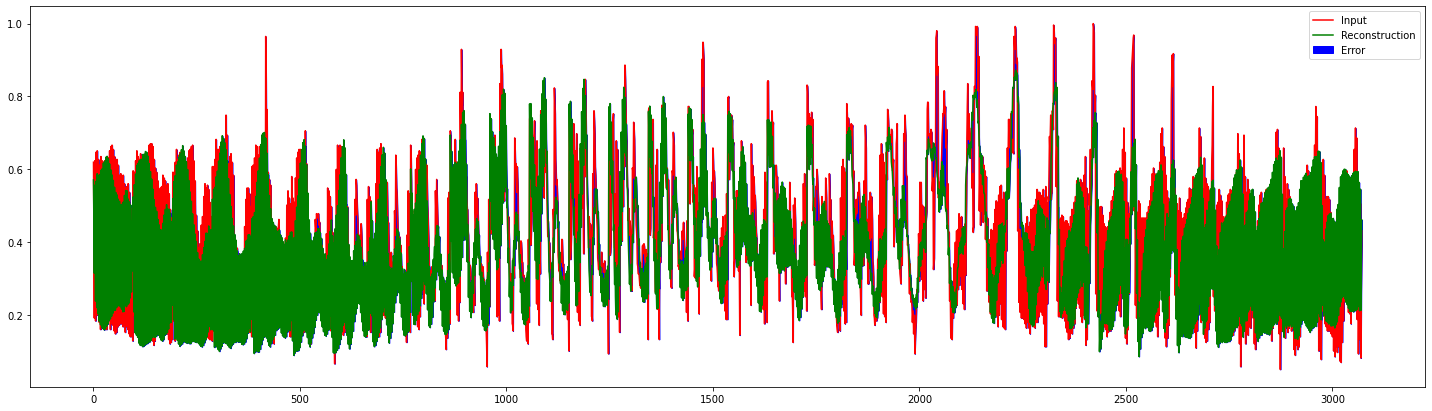

In [ ]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(32*32*3), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### **Distributions of the reconstruction losses and the calculation of the threshold.**

**Distribution of the reconstruction losses of the normal training data**



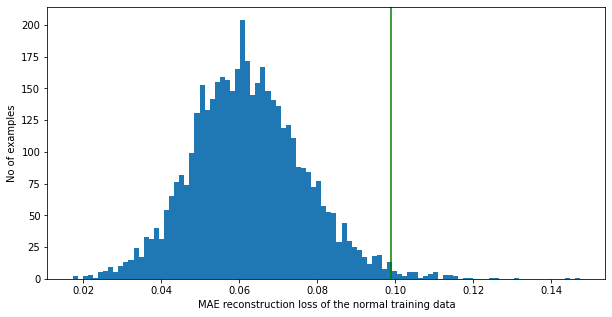

In [ ]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 3072), normal_data.reshape(-1, 3072))
plt.figure(figsize=(10,5))
plt.hist(train_loss[None,:], bins=100)
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the normal training data")
plt.ylabel("No of examples")
plt.show()

In [ ]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.062499244
Std:  0.01458947


In [ ]:
threshold_train_mean_2_5_std = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std: ", threshold_train_mean_2_5_std)

Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std:  0.09897291846573353


In [ ]:
threshold1 = threshold_train_mean_2_5_std

**Distribution of the reconstruction losses of the abnormal validation data**



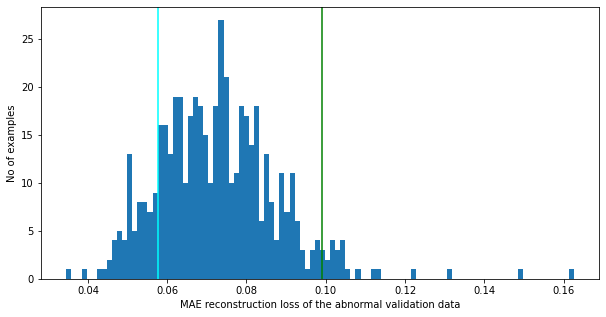

In [ ]:
reconstructions = autoencoder.predict(abnormal_valid_data)
abn_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), abnormal_valid_data.reshape(-1,3072))
plt.figure(figsize=(10,5))
plt.hist(abn_valid_loss[None, :], bins=100)
threshold2 = np.mean(abn_valid_loss) - np.std(abn_valid_loss)
plt.axvline(threshold2,c='cyan')
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the abnormal validation data")
plt.ylabel("No of examples")
plt.show()

In [ ]:
abnormal_valid_mean_loss = np.mean(abn_valid_loss)

In [ ]:
abnormal_valid_mean_loss , np.std(abn_valid_loss)

(0.07265811, 0.015068557)

In [ ]:
threshold2 = abnormal_valid_mean_loss - np.std(abn_valid_loss)
print("Threshold2: ", threshold2)

Threshold2:  0.05758955


**Distribution of the reconstruction losses of the normal validation data**

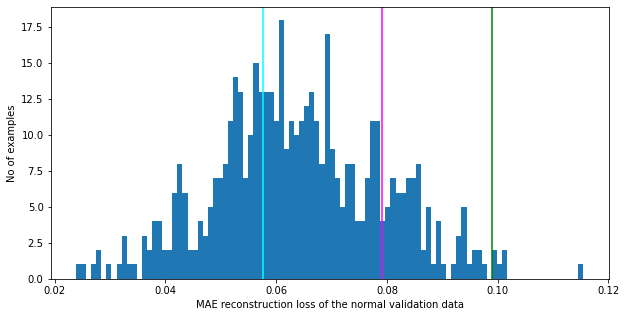

In [ ]:
reconstructions = autoencoder.predict(normal_valid_data)
nl_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), normal_valid_data.reshape(-1,3072))
plt.figure(figsize=(10,5))
plt.hist(nl_valid_loss[None, :], bins=100)
threshold3 = np.mean(nl_valid_loss) + np.std(nl_valid_loss)
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold1, c='g')
plt.xlabel("MAE reconstruction loss of the normal validation data")
plt.ylabel("No of examples")
plt.show()

In [ ]:
normal_valid_mean_loss = np.mean(nl_valid_loss)

In [ ]:
normal_valid_mean_loss , np.std(nl_valid_loss)

(0.064053506, 0.015127128)

In [ ]:
threshold3 = normal_valid_mean_loss + np.std(nl_valid_loss)
print("Threshold3: ", threshold3)

Threshold3:  0.079180636


**Calculation of a preliminary threshold based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)**

In [ ]:
Avg_of_threshold_2_3 = (threshold2 + threshold3)/2
print("Average of threshold 2 and 3: ", Avg_of_threshold_2_3)

Average of threshold 2 and 3:  0.06838509440422058


In [ ]:
threshold4 = Avg_of_threshold_2_3

### **Calculation of the threshold that gives the best accuracy on the validation data and set this as the threshold.**

In [ ]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 3072), data.reshape(-1, 3072))
  return tf.math.less(loss, threshold)

In [ ]:
increment = (abnormal_valid_mean_loss- normal_valid_mean_loss)/100
thresholds = np.arange(normal_valid_mean_loss, abnormal_valid_mean_loss, increment)
thrs_size = thresholds.shape[0]
accuracies = np.zeros(thrs_size)
for i in range(thrs_size):
  preds = predict(autoencoder, valid_data, thresholds[i])
  accuracies[i] = accuracy_score(preds, valid_labels_T_F)
argmax = np.argmax(accuracies)
valid_data_best_threshold = thresholds[argmax]
print("The best threshold based on validation data: ", valid_data_best_threshold)

The best threshold based on validation data:  0.06611860990524299


In [ ]:
thr_acc = np.zeros((thrs_size, 2))
thr_acc[:, 0] = thresholds
thr_acc[:, 1] = accuracies
thr_acc[argmax-2:argmax+3]

array([[0.06594652, 0.6146789 ],
       [0.06603256, 0.61671764],
       [0.06611861, 0.61875637],
       [0.06620466, 0.61569827],
       [0.0662907 , 0.61569827]])

In [ ]:
threshold5 = valid_data_best_threshold

In [ ]:
threshold = threshold5

#### **Distribution of the reconstruction losses of all the validation data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

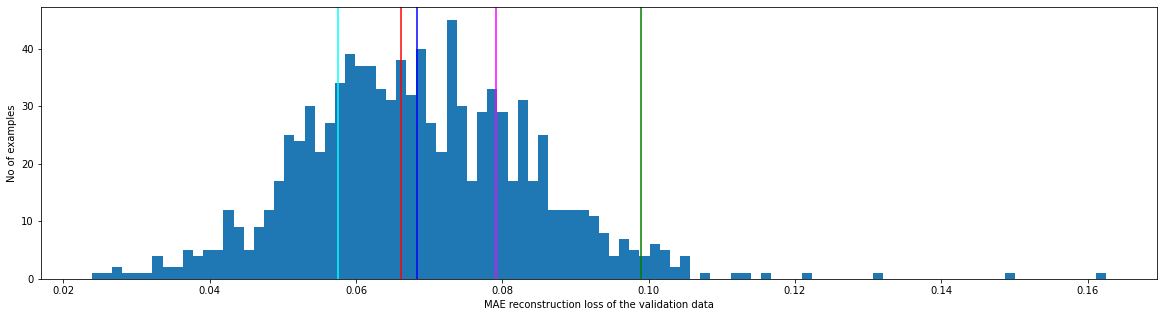

In [ ]:
reconstructions = autoencoder.predict(valid_data)
valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), valid_data.reshape(-1,3072))
plt.figure(figsize=(20,5))
plt.hist(valid_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the validation data")
plt.ylabel("No of examples")
plt.show()

#### **Distribution of the reconstruction losses of the test data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

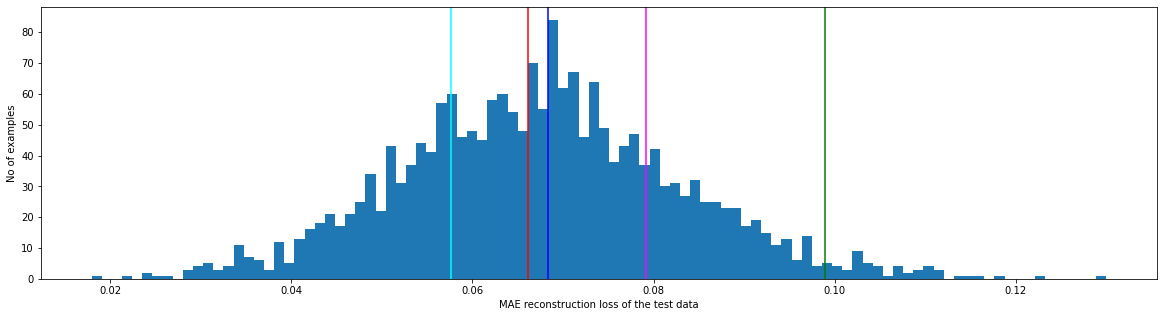

In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), test_data.reshape(-1,3072))
plt.figure(figsize=(20,5))
plt.hist(test_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the test data")
plt.ylabel("No of examples")
plt.show()

In [ ]:
reconstructions = autoencoder.predict(normal_test_data)
nl_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), normal_test_data.reshape(-1,3072))
np.mean(nl_test_loss) , np.std(nl_test_loss)

(0.062413763, 0.015323161)

In [ ]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), abnormal_test_data.reshape(-1,3072))
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.07234096, 0.013853612)

### **Calculation of the accuracy and the confusion matrix on the test data with threshold set based on the best threshold from the validation data**

In [ ]:
# def predict(model, data, threshold):
#  reconstructions = model.predict(data)
#  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 3072), data.reshape(-1, 3072))
#  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Normal Test Data Mean = {}".format(np.mean(nl_test_loss)))
  print("Normal Test Data Standard Deviation = {}".format(np.std(nl_test_loss)))
  print("Abnormal Test Data Mean = {}".format(np.mean(abn_test_loss)))
  print("Abnormal Test Data Standard Deviation = {}".format(np.std(abn_test_loss)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, valid_data_best_threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1072   928
 label: F   [[682   318]    1000
        T    [390   610]]   1000
Accuracy = 0.646
Normal Test Data Mean = 0.062413763254880905
Normal Test Data Standard Deviation = 0.015323161147534847
Abnormal Test Data Mean = 0.0723409578204155
Abnormal Test Data Standard Deviation = 0.01385361235588789
Precision = 0.6573275862068966
Recall = 0.61


In [ ]:
print("Threshold =", valid_data_best_threshold)

Threshold = 0.06611860990524299


In [ ]:
print(confusion_matrix(test_labels_T_F, preds))

[[682 318]
 [390 610]]


#### **Extra accuracy info**
**Just informative. Please record the above accuracy.**

#### Accuracy on the test data with threshold set based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)

In [ ]:
preds = predict(autoencoder, test_data, Avg_of_threshold_2_3)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             947   1053
 label: F   [[613   387]    1000
        T    [334   666]]   1000
Accuracy = 0.6395
Normal Test Data Mean = 0.062413763254880905
Normal Test Data Standard Deviation = 0.015323161147534847
Abnormal Test Data Mean = 0.0723409578204155
Abnormal Test Data Standard Deviation = 0.01385361235588789
Precision = 0.6324786324786325
Recall = 0.666


#### Accuracy on the test data with threshold set based on the mean of the training data MAE reconstruction losses + 2.5 std

In [ ]:
preds = predict(autoencoder, test_data, threshold_train_mean_2_5_std)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             53   1947
 label: F   [[39   961]    1000
        T    [14   986]]   1000
Accuracy = 0.5125
Normal Test Data Mean = 0.062413763254880905
Normal Test Data Standard Deviation = 0.015323161147534847
Abnormal Test Data Mean = 0.0723409578204155
Abnormal Test Data Standard Deviation = 0.01385361235588789
Precision = 0.5064201335387776
Recall = 0.986


# Automate experiments
Make sure to change the epochs to 100 when running this for real.

## The function itself

In [12]:
def test_and_train_model(normals, abnormals, results_dir):
    (x_train_0, y_train_0), (x_test, y_test) = keras.datasets.cifar10.load_data()

    x_train_0 = x_train_0.astype(np.float32) / 255
    x_test = x_test.astype(np.float32) / 255

    train_size = x_train_0.shape[0] * 9 // 10

    x_train, x_valid, y_train, y_valid = train_test_split(x_train_0, y_train_0, train_size = train_size)

    normal_data = x_train[np.isin(y_train, normals).flatten()]    # Normal training data (Normal digits)
    normal_labels = y_train[np.isin(y_train, normals).flatten()]  

    valid_data = x_valid[np.isin(y_valid, abnormals).flatten() | np.isin(y_valid, normals).flatten()]    # Validation data (both normal digits and the abnormal digit)
    valid_labels = y_valid[np.isin(y_valid, abnormals).flatten() | np.isin(y_valid, normals).flatten()]

    test_data = x_test[np.isin(y_test, abnormals).flatten() | np.isin(y_test, normals).flatten()]   # Test data (both normal digits and the abnormal digit)
    test_labels = y_test[np.isin(y_test, abnormals).flatten() | np.isin(y_test, normals).flatten()]

    test_labels_T_F = np.where(np.isin(test_labels, normals).flatten(), True, False) 
    # Array of T and F, T where test digits are normal and F where test digits are abnormal

    valid_labels_T_F = np.where(np.isin(valid_labels, normals).flatten(), True, False) 
    # Array of T and F, T where test digits are normal and F where test digits are abnormal

    normal_data.shape, normal_labels.shape, valid_data.shape, valid_labels.shape, test_data.shape, test_labels.shape

    normal_test_data = test_data[np.isin(test_labels, normals).flatten()]   # The normal digits in the test data
    abnormal_test_data = test_data[np.isin(test_labels, abnormals).flatten()]                          # The abnormal digits in the test data
    normal_test_labels = test_labels[np.isin(test_labels, normals).flatten()]   # Their labels
    abnormal_test_labels = test_labels[np.isin(test_labels, abnormals).flatten()]                          # Their labels

    normal_test_data.shape, abnormal_test_data.shape

    normal_valid_data = valid_data[np.isin(valid_labels, normals).flatten()]   # The normal digits in the valid data
    abnormal_valid_data = valid_data[np.isin(valid_labels, abnormals).flatten()]                           # The abnormal digits in the valid data
    normal_valid_labels = valid_labels[np.isin(valid_labels, normals).flatten()]   # Their labels
    abnormal_valid_labels = valid_labels[np.isin(valid_labels, abnormals).flatten()]                           # Their labels

    normal_valid_data.shape, abnormal_valid_data.shape

    """### **Building and training the network** """
    # Change model for every file
    class AnomalyDetector(Model):
      def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            Input(shape=(32, 32, 3)),
            # Conv2D(128, (3, 3), padding='same'),
            # Conv2D(128, (3, 3), padding='same'),
            # BatchNormalization(),
            # Activation('selu'),
            # MaxPooling2D((2, 2), padding='same'),
            Conv2D(64, (3, 3), padding='same'),
            Conv2D(64, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(32, (3, 3), padding='same'),
            Conv2D(32, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(16, (3, 3), padding='same'),
            Conv2D(16, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((2, 2), padding='same')])


        self.decoder = tf.keras.Sequential([
            Conv2D(16, (3, 3), padding='same'),
            Conv2D(16, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            UpSampling2D((2, 2)),
            Conv2D(32, (3, 3), padding='same'),
            Conv2D(32, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            UpSampling2D((2, 2)),
            Conv2D(64, (3, 3), padding='same'),
            Conv2D(64, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            UpSampling2D((2, 2)),
          #  Conv2D(128, (3, 3), padding='same'),
          #  Conv2D(128, (3, 3), padding='same'),
          #  BatchNormalization(),
          #  Activation('selu'),
          #  UpSampling2D((2, 2)),
            Conv2D(3, (3, 3), padding='same'),
            Conv2D(3, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('sigmoid')])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    autoencoder = AnomalyDetector()

    # autoencoder.compile(optimizer='adam', loss='mae')
    autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

    checkpoint_cb = keras.callbacks.ModelCheckpoint("AE_model", monitor="val_loss", save_best_only=True)

    history = autoencoder.fit(normal_data, normal_data, 
              epochs=1, 
              batch_size=128,
              validation_data=(normal_valid_data, normal_valid_data),
              callbacks=[checkpoint_cb],
              shuffle=True)

    
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.savefig(os.path.join(results_dir, 'loss_history.png'))
    plt.close()

    model = autoencoder
    model.summary(expand_nested=True, show_trainable=True)

    model_encoder = autoencoder.encoder
    # model_encoder.summary(expand_nested=True, show_trainable=True)

    model_decoder = autoencoder.decoder
    # model_decoder.summary(expand_nested=True, show_trainable=True)

    model_layers = np.array(model.layers)
    n_layers = model_layers.shape[0] 
    # np.concatenate((np.arange(n_layers).reshape(n_layers,1), model_layers.reshape(n_layers,1)), axis = 1)

    """### **The original and reconstructed images for the first 30 instances of the normal training data, validation data, normal validation data, abnormal validation data, test data, normal test data, and abnormal test data**"""

    def plot_image(image):
        plt.imshow(image, cmap="binary")
        plt.axis("off")

    def show_reconstructions(autoencoder, images, n_images=5):
        encoded_data = autoencoder.encoder(images[:n_images]).numpy()
        decoded_data = autoencoder.decoder(encoded_data).numpy()
        reconstructions = decoded_data
        fig = plt.figure(figsize=(n_images * 1.5, 3))
        for image_index in range(n_images):
            plt.subplot(2, n_images, 1 + image_index)
            plot_image(images[image_index])
            plt.subplot(2, n_images, 1 + n_images + image_index)
            plot_image(reconstructions[image_index])

    
    show_reconstructions(autoencoder, normal_data, 30)
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstructions_normal.png'))
    plt.close()

    show_reconstructions(autoencoder, valid_data, 30)
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstructions_valid.png'))
    plt.close()

    show_reconstructions(autoencoder, normal_valid_data, 30)
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstructions_normal_valid.png'))
    plt.close()

    show_reconstructions(autoencoder, abnormal_valid_data, 30)
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstructions_abnormal_valid.png'))
    plt.close()

    show_reconstructions(autoencoder, test_data, 30)
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstructions_test.png'))
    plt.close()

    show_reconstructions(autoencoder, normal_test_data, 30)
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstructions_normal_test.png'))
    plt.close()

    show_reconstructions(autoencoder, abnormal_test_data, 30)
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstructions_abnormal_test.png'))
    plt.close()
    

    encoded_data = autoencoder.encoder(normal_test_data).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()

    """**1-Dim plot of pixels of the first normal test data**"""
    
    plt.figure(figsize=(25,7))
    plt.plot(normal_test_data[0].ravel(), 'r')
    plt.plot(decoded_data[0].ravel(), 'g')
    plt.fill_between(np.arange(32*32*3), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstruction_error_normal.png'))
    plt.close()

    encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
    decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

    """**1-Dim plot of pixels of the first abnormal test data**"""
    
    plt.figure(figsize=(25,7))
    plt.plot(abnormal_test_data[0].ravel(), 'r')
    plt.plot(decoded_abn_data[0].ravel(), 'g')
    plt.fill_between(np.arange(32*32*3), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstruction_error_abnormal.png'))
    plt.close()

    """### **Distributions of the reconstruction losses and the calculation of the threshold.**

    **Distribution of the reconstruction losses of the normal training data**
    """

    reconstructions = autoencoder.predict(normal_data)
    train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 3072), normal_data.reshape(-1, 3072))

    plt.figure(figsize=(10,5))
    plt.hist(train_loss[None,:], bins=100)
    threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
    plt.axvline(threshold1,c='g')
    plt.xlabel("MAE reconstruction loss of the normal training data")
    plt.ylabel("No of examples")
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstruction_loss_normal_training_data.png'))
    plt.close()
    

    print("Mean: ", np.mean(train_loss))
    print("Std: ", np.std(train_loss))

    threshold_train_mean_2_5_std = np.mean(train_loss) + 2.5*np.std(train_loss)
    print("Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std: ", threshold_train_mean_2_5_std)

    threshold1 = threshold_train_mean_2_5_std

    """**Distribution of the reconstruction losses of the abnormal validation data**


    """

    reconstructions = autoencoder.predict(abnormal_valid_data)
    abn_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), abnormal_valid_data.reshape(-1,3072))
    
    plt.figure(figsize=(10,5))
    plt.hist(abn_valid_loss[None, :], bins=100)
    threshold2 = np.mean(abn_valid_loss) - np.std(abn_valid_loss)
    plt.axvline(threshold2,c='cyan')
    plt.axvline(threshold1,c='g')
    plt.xlabel("MAE reconstruction loss of the abnormal validation data")
    plt.ylabel("No of examples")
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstruction_loss_abnormal_validation_data.png'))
    plt.close()
    

    abnormal_valid_mean_loss = np.mean(abn_valid_loss)

    abnormal_valid_mean_loss , np.std(abn_valid_loss)

    threshold2 = abnormal_valid_mean_loss - np.std(abn_valid_loss)
    print("Threshold2: ", threshold2)

    """**Distribution of the reconstruction losses of the normal validation data**"""

    reconstructions = autoencoder.predict(normal_valid_data)
    nl_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), normal_valid_data.reshape(-1,3072))
    
    plt.figure(figsize=(10,5))
    plt.hist(nl_valid_loss[None, :], bins=100)
    threshold3 = np.mean(nl_valid_loss) + np.std(nl_valid_loss)
    plt.axvline(threshold3, c='magenta')
    plt.axvline(threshold2, c='cyan')
    plt.axvline(threshold1, c='g')
    plt.xlabel("MAE reconstruction loss of the normal validation data")
    plt.ylabel("No of examples")
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstruction_loss_abnormal_validation_data.png'))
    plt.close()

    normal_valid_mean_loss = np.mean(nl_valid_loss)

    normal_valid_mean_loss , np.std(nl_valid_loss)

    threshold3 = normal_valid_mean_loss + np.std(nl_valid_loss)
    print("Threshold3: ", threshold3)

    """**Calculation of a preliminary threshold based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)**"""

    Avg_of_threshold_2_3 = (threshold2 + threshold3)/2
    print("Average of threshold 2 and 3: ", Avg_of_threshold_2_3)

    threshold4 = Avg_of_threshold_2_3

    """### **Calculation of the threshold that gives the best accuracy on the validation data and set this as the threshold.**"""

    def predict(model, data, threshold):
      reconstructions = model.predict(data)
      loss = tf.keras.losses.mae(reconstructions.reshape(-1, 3072), data.reshape(-1, 3072))
      return tf.math.less(loss, threshold)

    increment = (abnormal_valid_mean_loss- normal_valid_mean_loss)/100
    thresholds = np.arange(normal_valid_mean_loss, abnormal_valid_mean_loss, increment)
    thrs_size = thresholds.shape[0]
    accuracies = np.zeros(thrs_size)
    for i in range(thrs_size):
      preds = predict(autoencoder, valid_data, thresholds[i])
      accuracies[i] = accuracy_score(preds, valid_labels_T_F)
    argmax = np.argmax(accuracies)
    valid_data_best_threshold = thresholds[argmax]
    print("The best threshold based on validation data: ", valid_data_best_threshold)

    thr_acc = np.zeros((thrs_size, 2))
    thr_acc[:, 0] = thresholds
    thr_acc[:, 1] = accuracies
    thr_acc[argmax-2:argmax+3]

    threshold5 = valid_data_best_threshold

    threshold = threshold5

    """#### **Distribution of the reconstruction losses of all the validation data (normal and abnormal)**

    The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

    The red line is the threshold that gives the best accuracy for the validation data.
    """

    reconstructions = autoencoder.predict(valid_data)
    valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), valid_data.reshape(-1,3072))

    
    plt.figure(figsize=(20,5))
    plt.hist(valid_loss[None, :], bins=100)
    plt.axvline(threshold, c='r')
    plt.axvline(threshold4, c='b')
    plt.axvline(threshold2, c='cyan')
    plt.axvline(threshold3, c='magenta')
    plt.axvline(threshold1, c='green')
    plt.xlabel("MAE reconstruction loss of the validation data")
    plt.ylabel("No of examples")
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstruction_loss_validation_data.png'))
    plt.close()

    """#### **Distribution of the reconstruction losses of the test data (normal and abnormal)**

    The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

    The red line is the threshold that gives the best accuracy for the validation data.
    """

    reconstructions = autoencoder.predict(test_data)
    test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), test_data.reshape(-1,3072))
    
    plt.figure(figsize=(20,5))
    plt.hist(test_loss[None, :], bins=100)
    plt.axvline(threshold, c='r')
    plt.axvline(threshold4, c='b')
    plt.axvline(threshold2, c='cyan')
    plt.axvline(threshold3, c='magenta')
    plt.axvline(threshold1, c='green')
    plt.xlabel("MAE reconstruction loss of the test data")
    plt.ylabel("No of examples")
    plt.show()
    plt.savefig(os.path.join(results_dir, 'reconstruction_loss_test_data.png'))
    plt.close()
    

    reconstructions = autoencoder.predict(normal_test_data)
    nl_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), normal_test_data.reshape(-1,3072))
    np.mean(nl_test_loss) , np.std(nl_test_loss)

    reconstructions = autoencoder.predict(abnormal_test_data)
    abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,3072), abnormal_test_data.reshape(-1,3072))
    np.mean(abn_test_loss) , np.std(abn_test_loss)

    """### **Calculation of the accuracy and the confusion matrix on the test data with threshold set based on the best threshold from the validation data**"""

    def predict(model, data, threshold):
      reconstructions = model.predict(data)
      loss = tf.keras.losses.mae(reconstructions.reshape(-1, 3072), data.reshape(-1, 3072))
      return tf.math.less(loss, threshold)

    def print_stats(predictions, labels):
      cf = confusion_matrix(labels, predictions)
      print("Confusion Matrix: \n prediction: F      T ")
      print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
      print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
      print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
      accuracy = accuracy_score(labels, predictions)
      print("Accuracy = {}".format(accuracy))
      normal_test_mean = np.mean(nl_test_loss)
      print("Normal Test Data Mean = {}".format(normal_test_mean))
      normal_test_stdev = np.std(nl_test_loss)
      print("Normal Test Data Standard Deviation = {}".format(normal_test_stdev))
      abnormal_test_mean = np.mean(abn_test_loss)
      print("Abnormal Test Data Mean = {}".format(abnormal_test_mean))
      abnormal_test_stdev = np.std(abn_test_loss)
      print("Abnormal Test Data Standard Deviation = {}".format(abnormal_test_stdev))
      print("Precision = {}".format(precision_score(labels, predictions)))
      print("Recall = {}".format(recall_score(labels, predictions)))
      return accuracy, normal_test_mean, normal_test_stdev, abnormal_test_mean, abnormal_test_stdev

    preds = predict(autoencoder, test_data, valid_data_best_threshold)
    stats = print_stats(preds, test_labels_T_F)

    print("Threshold =", valid_data_best_threshold)

    print(confusion_matrix(test_labels_T_F, preds))

    """#### **Extra accuracy info**
    **Just informative. Please record the above accuracy.**

    #### Accuracy on the test data with threshold set based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)
    """

    preds = predict(autoencoder, test_data, Avg_of_threshold_2_3)
    print_stats(preds, test_labels_T_F)

    """#### Accuracy on the test data with threshold set based on the mean of the training data MAE reconstruction losses + 2.5 std"""

    preds = predict(autoencoder, test_data, threshold_train_mean_2_5_std)
    print_stats(preds, test_labels_T_F)

    # return only the item we need
    return stats


## helper code

In [13]:
def run_experiments(normals, abnormals):
  dirname = 'normals=' + ','.join(map(str,normals)) + ',abnormals=' + ','.join(map(str, abnormals))
  results_dir = os.path.join('VAE', dirname)
  if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
  filename = os.path.join(results_dir, 'results.csv')
  res = np.empty([3,5])
  for i in range(1):
    print(i+1, 'out of', 3)
    loop_dir = os.path.join(results_dir, str(i))
    if not os.path.isdir(loop_dir):
      os.makedirs(loop_dir)
    res[i] = test_and_train_model(normals, abnormals, loop_dir)
  res.tofile(filename, sep=',')

## the experiments

1 out of 3
36/36 [==============================] - 8s 166ms/step - loss: 0.6562 - val_loss: 0.7375
Model: "anomaly_detector_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential_8 (Sequential)   (None, 4, 4, 16)          73824     Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_56 (Conv2D)        (None, 32, 32, 64)        1792      Y          |
|                                                                          |
| conv2d_57 (Conv2D)        (None, 32, 32, 64)        36928     Y          |
|                                                                          |
| batch_normalization_28 (Bat  (None, 32, 32, 64)     256       Y          |
| chNormalization)                                                         |
|                                                                          |
| activation_28 (Activati

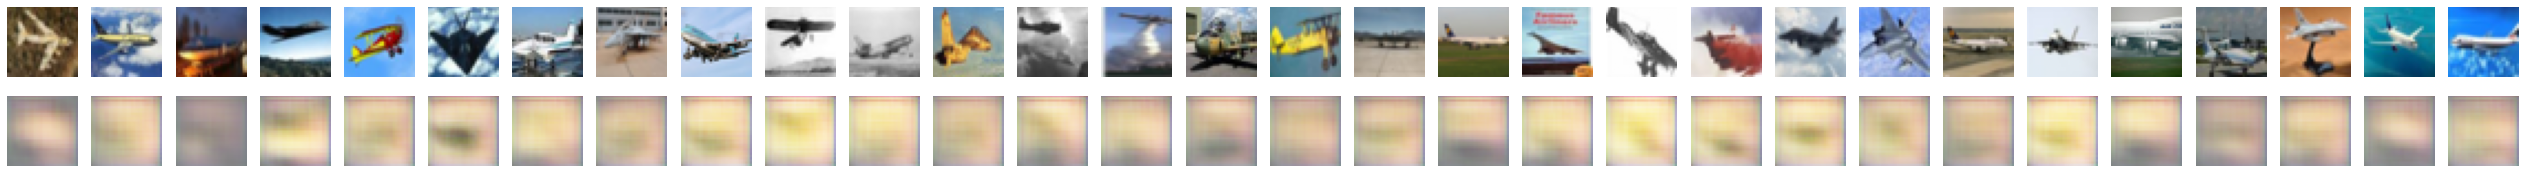

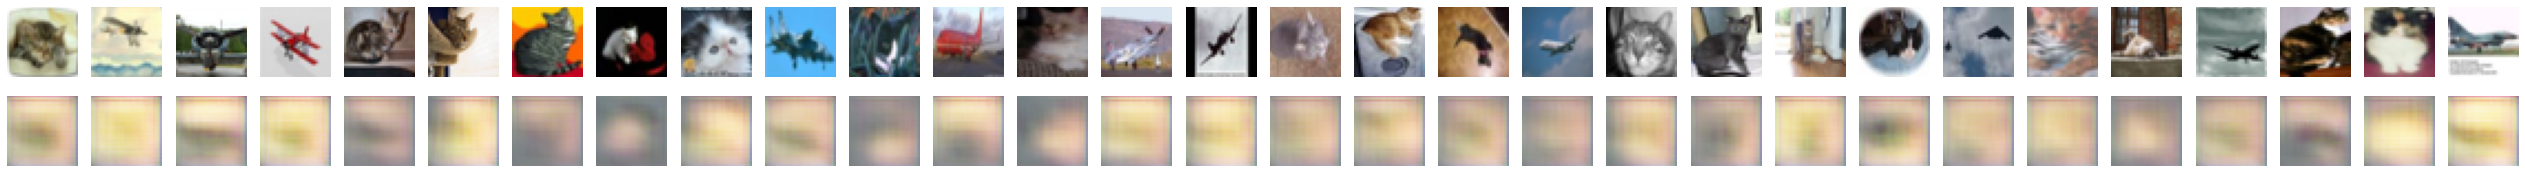

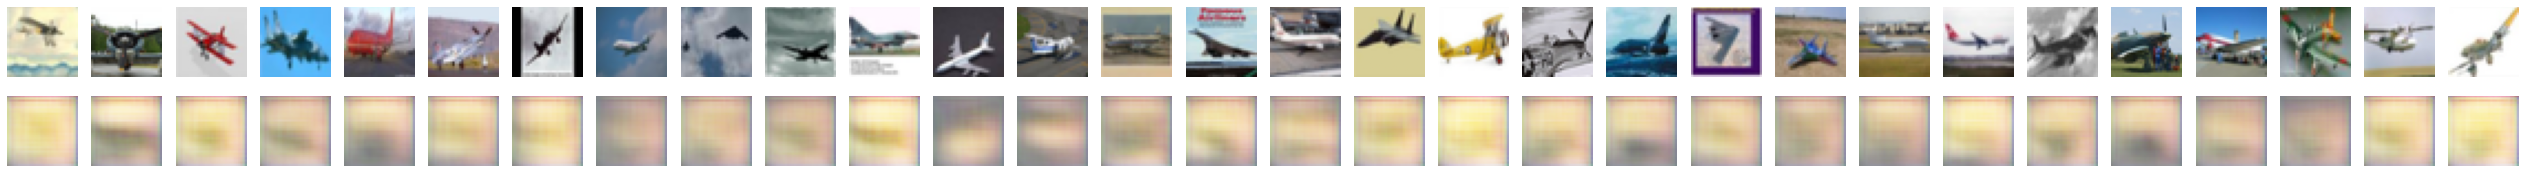

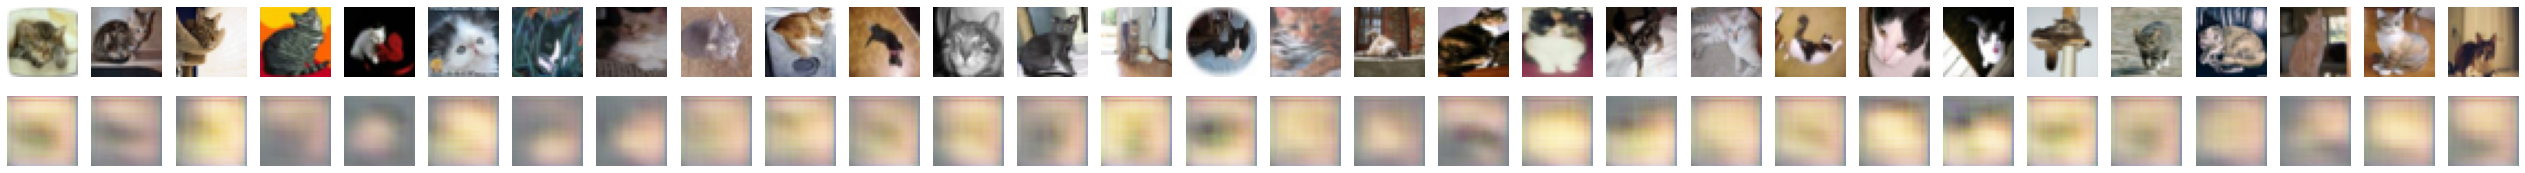

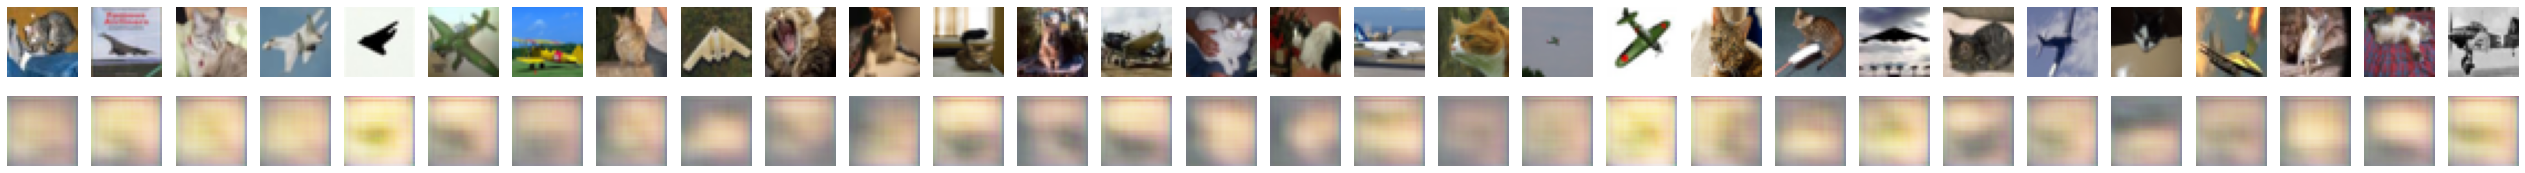

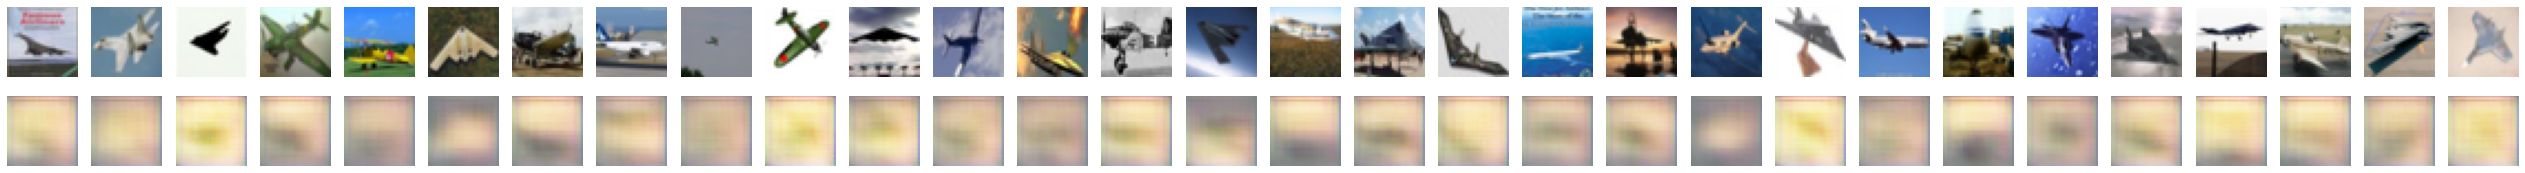

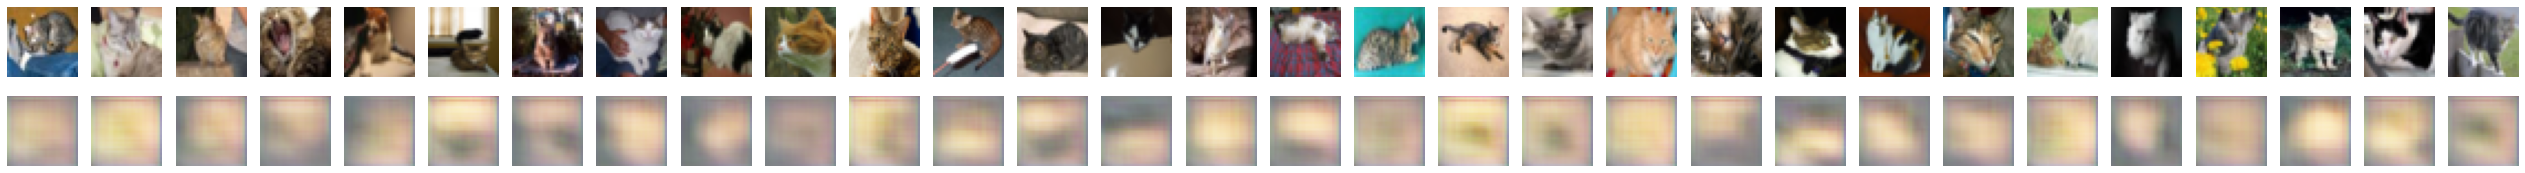

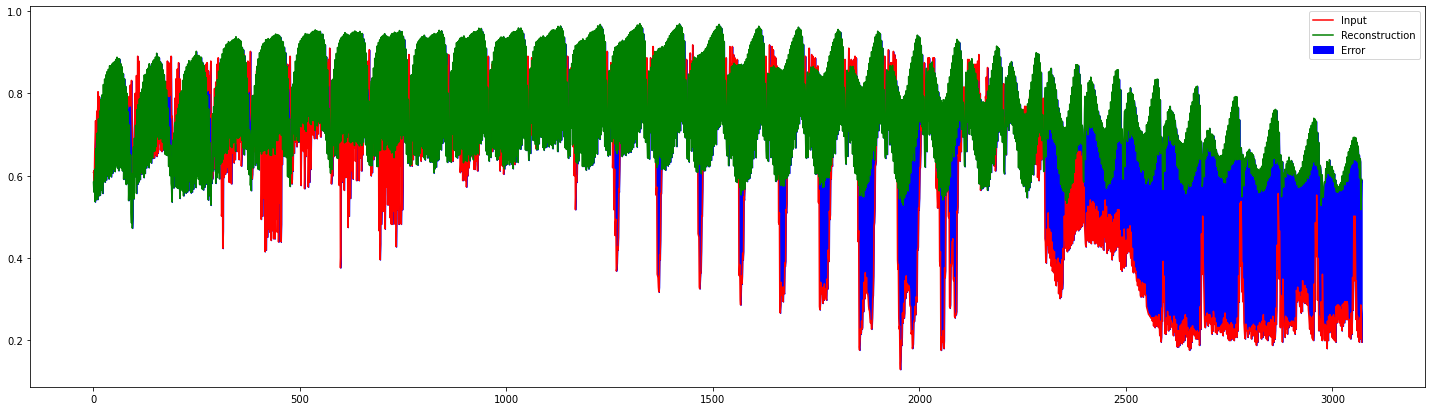

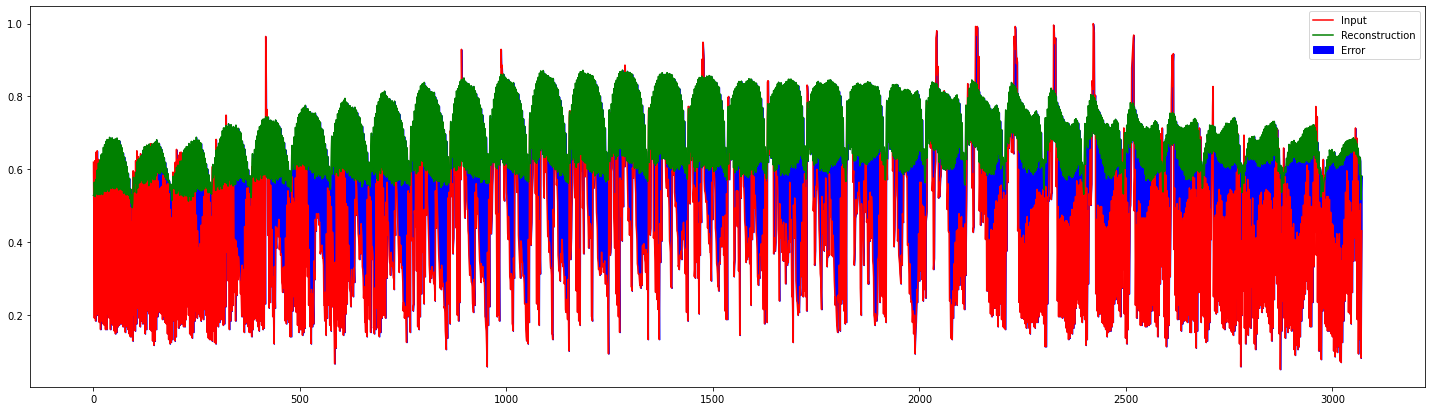

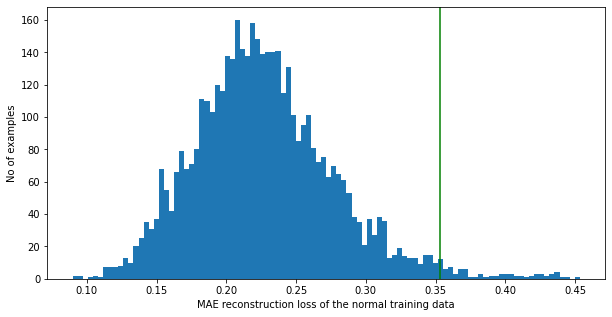

Mean:  0.22711398
Std:  0.050478123
Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std:  0.3533092848956585


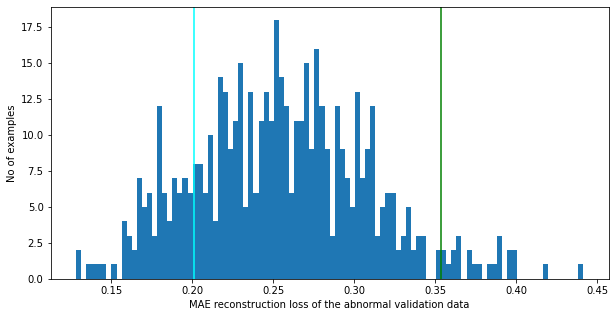

Threshold2:  0.20110205


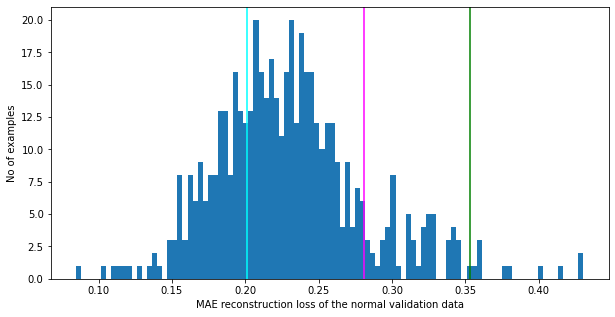

Threshold3:  0.2810354
Average of threshold 2 and 3:  0.24106872081756592
The best threshold based on validation data:  0.24800078347325244


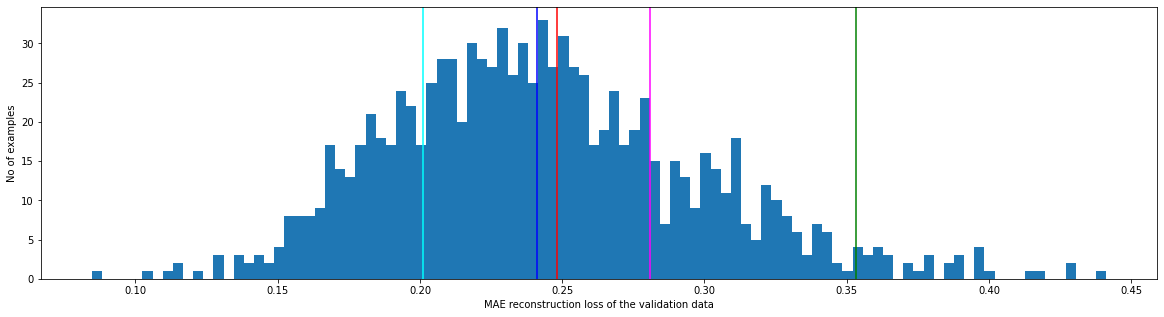

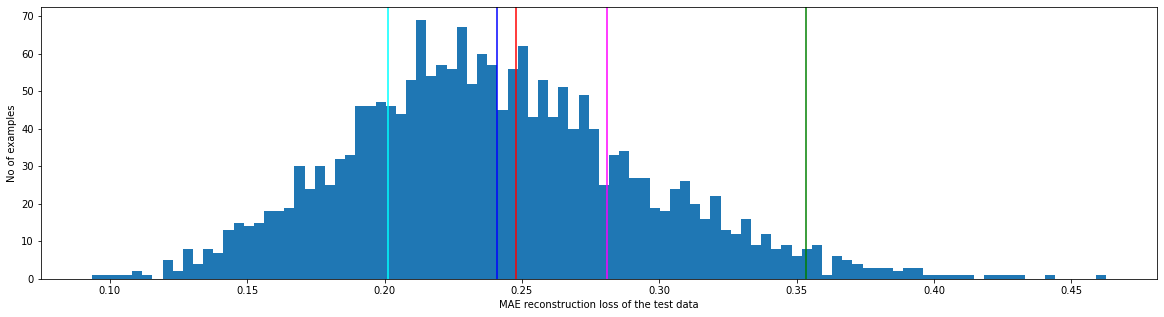

Confusion Matrix: 
 prediction: F      T 
             825   1175
 label: F   [[561   439]    1000
        T    [264   736]]   1000
Accuracy = 0.6485
Normal Test Data Mean = 0.2228832095861435
Normal Test Data Standard Deviation = 0.04831399768590927
Abnormal Test Data Mean = 0.25715798139572144
Abnormal Test Data Standard Deviation = 0.053809717297554016
Precision = 0.6263829787234042
Recall = 0.736
Threshold = 0.24800078347325244
[[561 439]
 [264 736]]
Confusion Matrix: 
 prediction: F      T 
             919   1081
 label: F   [[604   396]    1000
        T    [315   685]]   1000
Accuracy = 0.6445
Normal Test Data Mean = 0.2228832095861435
Normal Test Data Standard Deviation = 0.04831399768590927
Abnormal Test Data Mean = 0.25715798139572144
Abnormal Test Data Standard Deviation = 0.053809717297554016
Precision = 0.633672525439408
Recall = 0.685
Confusion Matrix: 
 prediction: F      T 
             58   1942
 label: F   [[48   952]    1000
        T    [10   990]]   1000
Accuracy 

In [14]:
normals = [0] # airplane
abnormals = [3] # cat
run_experiments(n, a)